In [ ]:
!pip install alpaca_trade_api

In [ ]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRegressor, XGBRFClassifier

sns.set(rc={"figure.figsize":(20, 10)}) #width=3, #height=4


In [ ]:

def import_data(api, dates):
  btc = api.get_crypto_bars('BTCUSD','15Min', dates[0],dates[1]).df
  btc = btc.reset_index()
  btc = btc[btc['exchange'] == 'CBSE']
  dates = pd.to_datetime(btc['timestamp']).dt.tz_convert(None)
  btc['time'] = (dates - pd.Timestamp('1970-01-01')) //pd.Timedelta('1s')
  return btc

def add_lag(df, col_to_lag, lag):
  dataset = df.copy()
  for i in range(lag):
    dataset[f'{col_to_lag}_lag_{i+1}'] = dataset[col_to_lag].shift(i+1)
  return dataset

def create_target(df_close, future_step,target_from):
  df = df_close.copy()
  df['future_'+ str(future_step)] = df['close'].shift(-future_step)
  df['diff'] = df['future_'+ str(future_step)] - df['close']
  df['class'] = np.where((df['diff'] > 0), 1, 0)
  return df

def plot_dataset(df):
  n = 1
  for name in df.columns:
    for name2 in df.columns:
      size = df.columns.shape[0]
      ax = plt.subplot(size,size,n)
      plt.scatter(df[name], df[name2], linewidths = 0.1)
      plt.title(name +' vs '+name2)
      plt.xlabel(name)
      plt.ylabel(name2)
      plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=1.1, wspace=0.4, hspace=0.4)
      n+=1
def make_dataset(lag_num,future ,dates,api):
  btc = import_data(api, dates)
  data = create_target(pd.DataFrame(btc['close']), future, 'close')
  lag = add_lag(pd.DataFrame(data['close']), 'close', lag_num)
  dataset = pd.concat([lag, data.drop('close', axis = 1)], axis = 1)
  dataset['time'] = btc['time']
  dataset = dataset.iloc[lag_num:]
  dataset = dataset.iloc[0:-future]
  return dataset

In [ ]:
credentials = {'key':'PKEK13ZV89MV6G9JVS76',
        'secret_key':'HoWeAjGDcmOyv8ogQMz7NHueC7j5K6rj0qJgaN4G',
        'url':'https://paper-api.alpaca.markets'}
dates = ['2021-06-01', '2022-07-01']
alpaca = tradeapi.REST(credentials['key'],credentials['secret_key'], base_url = credentials['url'])
data = make_dataset(2, 4, dates,alpaca)

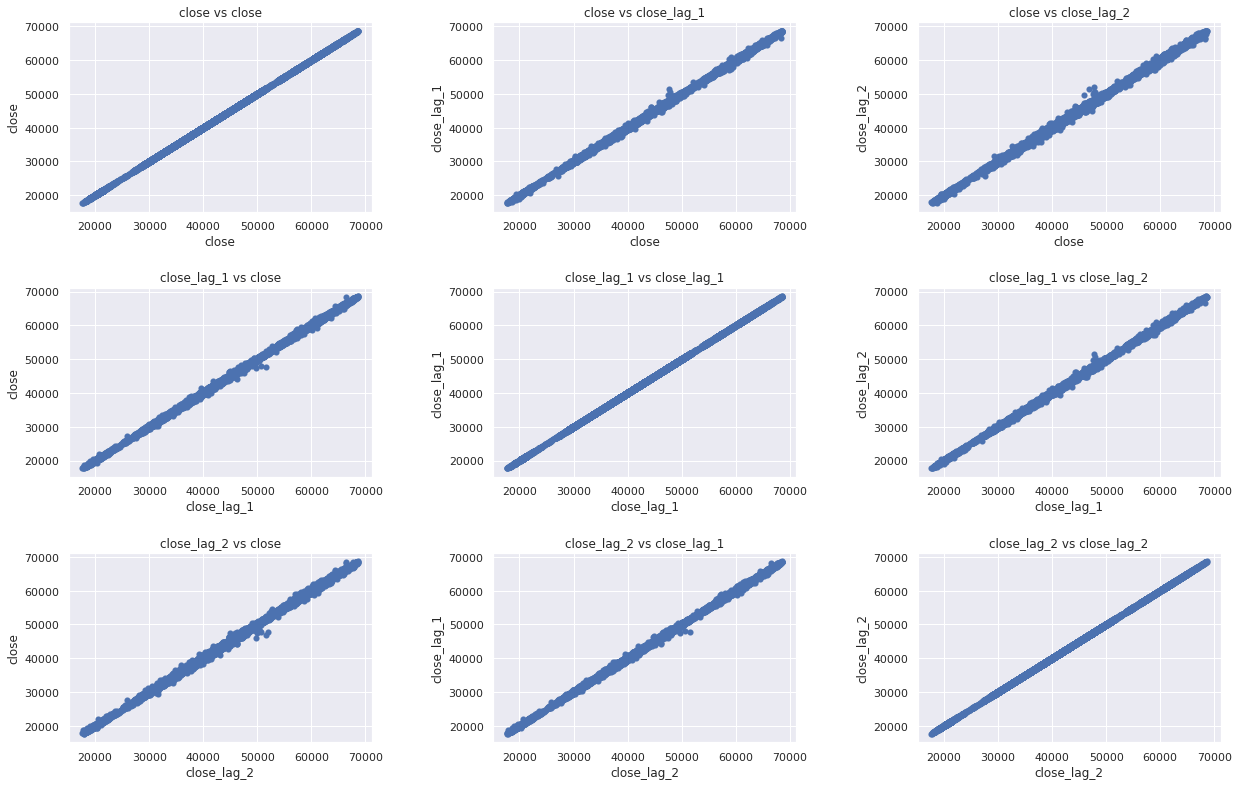

In [ ]:
plot_dataset(data[['close','close_lag_1', 'close_lag_2']])

In [ ]:


def train_test(model,data,train_index, feature_cols, target, classification):
  mod = model
  train = data.iloc[:train_index]
  test = data.iloc[train_index:]

  mod.fit(train[feature_cols], train[target])
  train_pred = mod.predict(train[feature_cols])
  y_pred = mod.predict(test[feature_cols])
  if classification:
    print('Training Accuracy: ', accuracy_score(train[target], train_pred))
    print('Test Accuracy: ',accuracy_score(test[target], y_pred))
  else:
    print('Training RMSE: ', rmse(train[target], train_pred))
    print('Test RMSE: ',rmse(test[target], y_pred))
  return y_pred

In [ ]:
rf = LinearRegression()
feature_cols = data.columns[:3]

target = 'future_4'
#y_pred = train_test(rf,data,, features,'future_1', False)
train_index = int(data.shape[0]*.70)
train = data.iloc[:train_index]
test = data.iloc[train_index:]

rf.fit(train[feature_cols], train[target])
train_pred = rf.predict(train[feature_cols])
y_pred = rf.predict(test[feature_cols])
print('Training RMSE: ', rmse(train[target], train_pred))
print('Test RMSE: ',rmse(test[target], y_pred))

Training RMSE:  341.651052555655
Test RMSE:  247.85233544041637


In [ ]:
test['y_pred'] = y_pred
test['y_pred_diff'] = test['future_4'] - test['y_pred']
test['mvnt'] = np.where((test['y_pred_diff']) > 0,1,0)
accuracy_score(test['mvnt'],test['class'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

0.9788551711934884

In [ ]:
test

,close,close_lag_1,close_lag_2,future_4,diff,class,time,y_pred,y_pred_diff,mvnt
64093,39331.0,39394.0,39408.0,39154.0,-177.0,0,1646553600,39338.741254,-184.741254,0
64095,39311.0,39331.0,39394.0,38841.0,-470.0,0,1646554500,39318.142643,-477.142643,0
64097,39223.0,39311.0,39331.0,38846.0,-377.0,0,1646555400,39231.920739,-385.920739,0
64099,39147.0,39223.0,39311.0,38702.0,-445.0,0,1646556300,39156.977713,-454.977713,0
64101,39154.0,39147.0,39223.0,38257.0,-897.0,0,1646557200,39160.488011,-903.488011,0
...,...,...,...,...,...,...,...,...,...,...
95094,19166.0,19130.0,19224.0,19106.0,-60.0,0,1656729900,19186.258562,-80.258562,0
95097,19169.0,19166.0,19130.0,19133.0,-36.0,0,1656730800,19187.732068,-54.732068,0
95100,19131.0,19169.0,19166.0,19160.0,29.0,1,1656731700,19152.065473,7.934527,1
95103,19066.0,19131.0,19169.0,19173.0,107.0,1,1656732600,19089.047135,83.952865,1


In [ ]:
rmse(test['diff'], test['y_pred_diff'])

11.869512822853077

In [ ]:
alpaca = tradeapi.REST(cred['key'],cred['secret_key'], base_url = cred['url'])
bars = alpaca.get_crypto_bars('BTCUSD', TimeFrame.Minute).df

In [ ]:
bars

,exchange,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2022-07-02 05:00:00+00:00,CBSE,19168.79,19177.19,19166.64,19174.19,4.363084,340,19172.349896
2022-07-02 05:00:00+00:00,FTXU,19173.00,19176.00,19173.00,19176.00,0.209900,4,19175.921391
2022-07-02 05:01:00+00:00,CBSE,19174.16,19174.16,19163.16,19163.93,3.552079,289,19166.688104
2022-07-02 05:02:00+00:00,CBSE,19163.92,19165.45,19154.70,19163.29,6.079465,303,19159.031117
2022-07-02 05:02:00+00:00,FTXU,19160.00,19160.00,19160.00,19160.00,0.130500,1,19160.000000
...,...,...,...,...,...,...,...,...
2022-07-02 08:29:00+00:00,CBSE,19147.37,19163.48,19144.85,19161.16,5.635424,157,19152.670631
2022-07-02 08:29:00+00:00,FTXU,19154.00,19156.00,19154.00,19156.00,0.416900,3,19154.263373
2022-07-02 08:30:00+00:00,CBSE,19160.46,19165.44,19158.61,19163.54,3.771638,257,19160.950761


In [ ]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import numpy as np
from time import sleep
from datetime import datetime
from dateutil.relativedelta import relativedelta

def import_data(api, dates):
  btc = api.get_crypto_bars('BTCUSD','15Min', dates[0],dates[1]).df
  btc = btc.reset_index()
  btc = btc[btc['exchange'] == 'CBSE']
  dates = pd.to_datetime(btc['timestamp']).dt.tz_convert(None)
  btc['time'] = (dates - pd.Timestamp('1970-01-01')) //pd.Timedelta('1s')
  return btc

def add_lag(df, col_to_lag, lag):
  dataset = df.copy()
  for i in range(lag):
    dataset[f'{col_to_lag}_lag_{i+1}'] = dataset[col_to_lag].shift(i+1)
  return dataset

def create_target(df_close, future_step,target_from):
  df = df_close.copy()
  df['future_'+ str(future_step)] = df['close'].shift(-future_step)
  df['diff'] = df['future_'+ str(future_step)] - df['close']
  df['class'] = np.where((df['diff'] > 0), 1, 0)
  return df

def make_dataset(lag_num,future ,dates,api):
  btc = import_data(api, dates)
  data = create_target(pd.DataFrame(btc['close']), future, 'close')
  lag = add_lag(pd.DataFrame(data['close']), 'close', lag_num)
  dataset = pd.concat([lag, data.drop('close', axis = 1)], axis = 1)
  dataset['time'] = btc['time']
  dataset = dataset.iloc[lag_num:]
  dataset = dataset.iloc[0:-future]
  return dataset

def get_position(symbol):
  positions = alpaca.list_positions()
  for p in positions:
    if p.symbol == symbol:
      return float(p.qty)
  return 0

def get_input(symbol, length):
  bars = alpaca.get_crypto_bars(symbol, '1Min').df
  bars = bars[bars['exchange'] == 'CBSE']
  out = {}
  out['close'] = bars['close'].iloc[-1]
  for _ in range(1, length+1):
    i = 2
    out['close_lag_'+str(_)] = bars['close'].iloc[-i]
    i+=1
  return pd.DataFrame(out, index = [0])

def rmse(actual, predict):
  return np.sqrt(np.mean((actual - predict)**2))

def train_model(training_data, tr_cols, target):
  print(training_data.columns)
  lm = LinearRegression()
  lm.fit(training_data[tr_cols], training_data[target])
  return lm

def test(model,data,train_index, feature_cols, target):
  mod = model
  train = data.iloc[:train_index]
  test = data.iloc[train_index:]
  train_pred = mod.predict(train[feature_cols])
  y_pred = mod.predict(test[feature_cols])
  print('Training RMSE: ', rmse(train[target], train_pred))
  print('Test RMSE: ',rmse(test[target], y_pred))
  
  test['y_pred'] = y_pred
  test['y_pred_diff'] = test['future_60'] - test['y_pred']
  test['mvnt'] = np.where((test['y_pred_diff']) > 0,1,0)
  print('Test Accuracy: ',accuracy_score(test['mvnt'],test['class']))

credentials = {'key':'PKK2V8FWXOULGJDE9BGE',
               'secret_key':'PfBXRiWDl8wMahcA7ebn4Q1SrtOWFtGprKksg8bA',
               'url':'https://paper-api.alpaca.markets'}


print('*** ACTIVATING ***')
alpaca = tradeapi.REST(credentials['key'],credentials['secret_key'], base_url = credentials['url'])
print('*** Connected to API *** ')
portfolio_value = float(alpaca.get_account().equity)


print('*** CLOSING OPEN POSITIONS ***')
alpaca.close_all_positions()

print('*** HOURLY MODE ***')
print('Current Value:', portfolio_value) 


#train once


#test(model,hist_data,int(hist_data.shape[0]*.7), hist_data.columns[:-4], 'future_4')
#run forever
while True:

  today = datetime.now().isoformat()[:10]
  yr_ago = (datetime.now() - relativedelta(days = 7)).isoformat()[:10]
  dates = [yr_ago, today]
  hist_data = make_dataset(10, 60, dates,alpaca)
  print(hist_data.columns)
  model = train_model(hist_data,hist_data.columns[:-4], 'future_60')
  #test(model,hist_data,int(hist_data.shape[0]*.7), hist_data.columns[:-4], 'future_4' )
  input = get_input('BTCUSD', 10) 
  y_pred = model.predict(input)
  threshold = input['close'].iloc[0]
 
  if get_position('BTCUSD') == 0 and y_pred > threshold: #if not holding and going up BUY
    alpaca.submit_order('BTCUSD', qty = 1, side = 'buy')
    sleep(0.5)
    pos = alpaca.get_position('BTCUSD').market_value
    new_value = float(alpaca.get_account().equity)
    print(str(datetime.now())[:19]+f' - Bought BTC @ {pos} | Projected Value = {y_pred} | Threshold: {threshold} | Portfolio Value: {new_value}' )

  elif (get_position('BTCUSD') == 1):# and y_pred < input['close']) or (new_value - portfolio_value) < -500: #if holding and going down SELL
    alpaca.close_position('BTCUSD')
    new_value = float(alpaca.get_account().equity)
    if new_value > portfolio_value:
      print(str(datetime.now())[:19]+f'- **SOLD BTC @ {new_value - portfolio_value}$ PROFIT** | Portfolio Value: {new_value}')
      porfolio_value = new_value
    else:
      print(str(datetime.now())[:19]+f'- Sold BTC @ {new_value - portfolio_value}$ loss** | Portfolio Value: {new_value}')
      porfolio_value = new_value
    
  # elif get_position('BTCUSD'):
  #   curr_btc_value = alpaca.get_position('BTCUSD').market_value
  #   print(str(datetime.now())[:19]+f' - Position Held @ {curr_btc_value} | Current Profit: {new_value - portfolio_value} | Projected Value: {y_pred} | Portfolio Value: {new_value}')
  else:
    cl = input['close'].iloc[0]
    print(str(datetime.now())[:19]+f'- No Action Taken | Close: {cl} | Predicted: {y_pred} | Threshold: {threshold} | Portfolio Value: {portfolio_value}')
  
  if get_position('BTCUSD') == 1:
    print('Wainting 1 Hour')
    sleep(3600) #sleep for an hour
    

*** ACTIVATING ***
*** Connected to API *** 
*** CLOSING OPEN POSITIONS ***
*** HOURLY MODE ***
Current Value: 99505.128
Index(['close', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4',
       'close_lag_5', 'close_lag_6', 'close_lag_7', 'close_lag_8',
       'close_lag_9', 'close_lag_10', 'future_60', 'diff', 'class', 'time'],
      dtype='object')
Index(['close', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4',
       'close_lag_5', 'close_lag_6', 'close_lag_7', 'close_lag_8',
       'close_lag_9', 'close_lag_10', 'future_60', 'diff', 'class', 'time'],
      dtype='object')
2022-07-03 10:11:14 - Bought BTC @ 19021 | Projected Value = [19038.40146815] | Threshold: 19028.56 | Portfolio Value: 99389.996
Wainting 1 Hour


KeyboardInterrupt: ignored

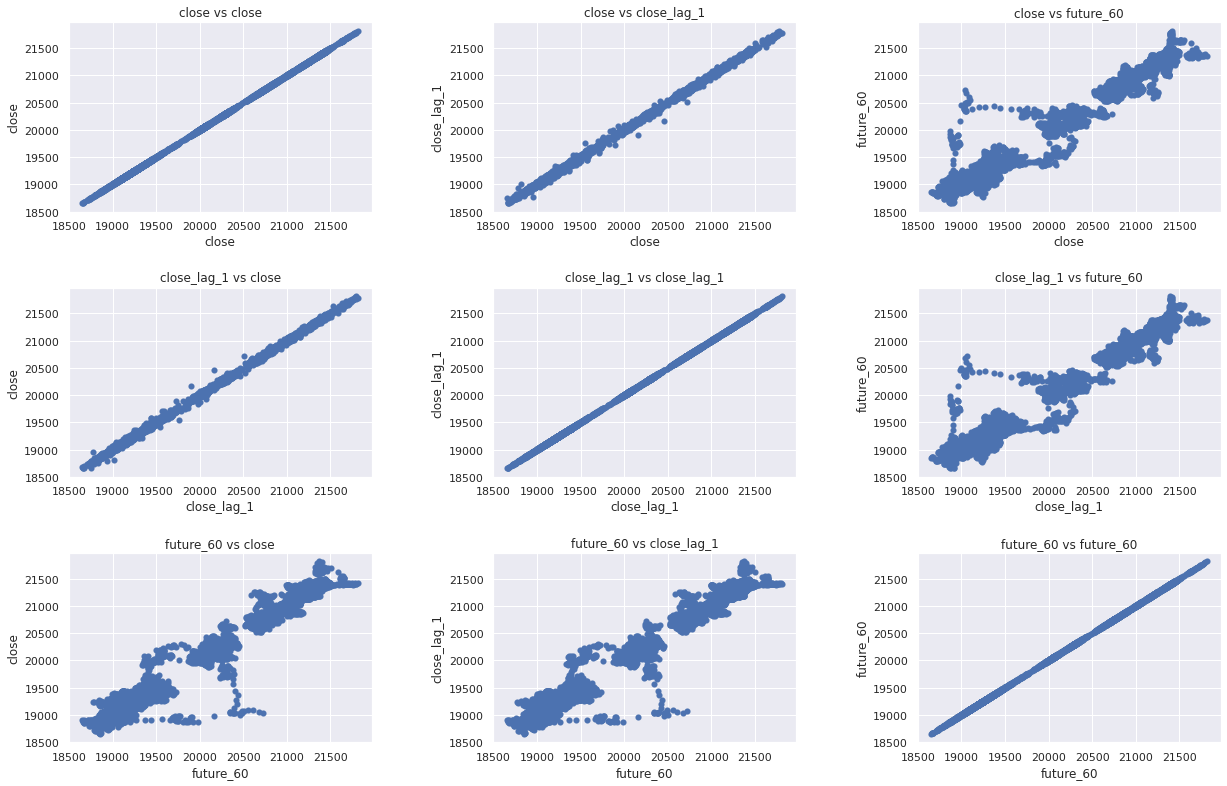

In [ ]:
plot_dataset(hist_data[['close', 'close_lag_1','future_60']])